# Import Libraries

In [ ]:
# Libraries for data manipulation
import pandas as pd
import numpy as np

# Libraries for deeplearning
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Libraries for image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import Image

# Libraries for interacting with folder and files
import os

# Libraries for load json
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
K.clear_session()

# Check Data

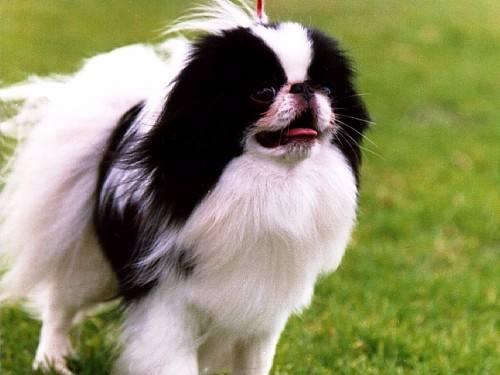

In [ ]:
# View one of the images
Image('/content/drive/My Drive/Capstone Project/Test Images for Image Recognition Feature/n02085782-Japanese_spaniel/n02085782_1039.jpg')

# Data Manipulation

In [ ]:
# Get the list of dogs' breeds
folder_path = '/content/drive/MyDrive/Capstone Project/Dogs Images Data/images/Images'
breeds_folder_name = os.listdir(folder_path)
breeds_name_only = [breed.split('-',1)[1] for breed in breeds_folder_name]
breeds_name_only[:20]

NameError: ignored

In [ ]:
# Define empty list to contain the images and labels
X = []
y = []

# Define the folder's full path
full_paths = [folder_path + '/{}'.format(breed) for breed in breeds_folder_name]

# Store img file name and label in X and y
for i, path in enumerate(full_paths):
  for img in os.listdir(path):
    X.append(path + '/' + img)
    y.append(breeds_name_only[i])

In [ ]:
# Shuffle X and y
import random

img_label_combined = list(zip(X,y))
random.shuffle(img_label_combined)
X[:], y[:] = zip(*img_label_combined)

In [ ]:
# Check the number of rows in X and y\
print('The number of data in X:', len(X))
print('The number of data in y:', len(y))

The number of data in X: 20583
The number of data in y: 20583


In [ ]:
# Take a subset of data (10k rows)
X = X[:5000]
y = y[:5000]

# Encode Label

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the label data
y_ohe = label_encoder.fit_transform(y)

# Prepare Train, Validation, and Test Data

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img

image_data = np.array([img_to_array(load_img(image_file, target_size=(299, 299))) for image_file in X])

In [ ]:
# Clear some space from the memory
import gc
del X
del y
gc.collect()

728

In [ ]:
# Split the image_data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(image_data, y_ohe, test_size=0.1, stratify=np.array(y_ohe), random_state=0)

# Clear some space from the memory

del image_data
gc.collect()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=np.array(y_train), random_state=0)

In [ ]:
print('Train Dataset Size: ', X_train.shape)
print('Validation Dataset Size: ', X_val.shape)
print('Test Dataset Size: ', X_test.shape)
print('Train Label Size: ', len(y_train))
print('Validation Label Size: ', len(y_val))
print('Test Label Size: ', len(y_test))

Train Dataset Size:  (4050, 299, 299, 3)
Validation Dataset Size:  (450, 299, 299, 3)
Test Dataset Size:  (500, 299, 299, 3)
Train Label Size:  4050
Validation Label Size:  450
Test Label Size:  500


# Image Augmentation

In [ ]:
# Define some hyperparameters
batch_size = 32
epochs = 20

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the train generator and do some image augmentations
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=30,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)
train_generator = train_data_generator.flow(X_train, y_train, shuffle=False, batch_size=batch_size)

# Define the validation generator
validation_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_data_generator.flow(X_val, y_val, shuffle=False, batch_size=batch_size)

# Model Training

In [ ]:
K.clear_session()

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2

# Import the Inception V3 original model, but discard the top dense layer for original classification
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

# Add the additional layers
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=120, activation='softmax')
])

# Freeze the pretrained Inception V3 layers
model.layers[0].trainable = False

NameError: ignored

In [ ]:
print('Number of trainable weights after freezing the base layer:', len(model.trainable_weights))

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

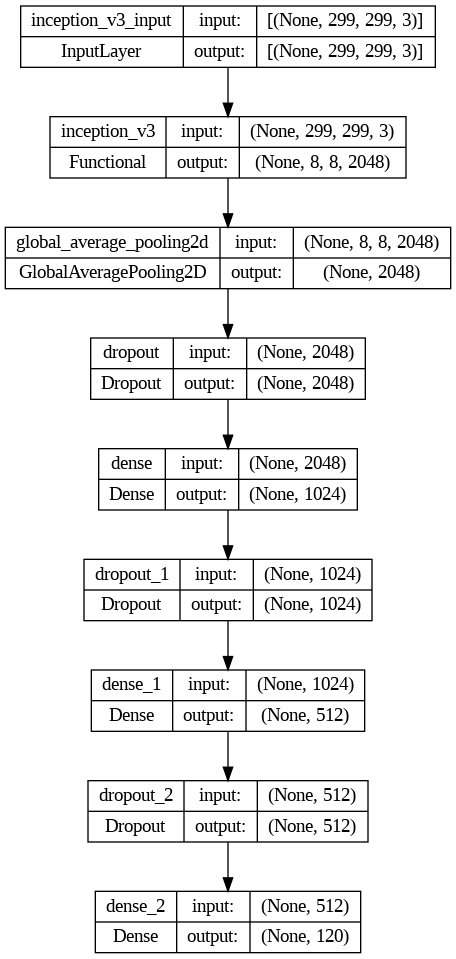

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='inception_model_modified.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define the step_size to use
train_step_size = X_train.shape[0] // batch_size
validation_step_size = X_val.shape[0] // batch_size

# Train the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_step_size,
                    validation_data=validation_generator,
                    validation_steps=validation_step_size,
                    epochs=epochs)

<ipython-input-27-4a6a34c5f9eb>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/20


Exception ignored in: <function _xla_gc_callback at 0x7fc4e7458700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 103, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


  1/126 [..............................] - ETA: 2:31:22 - loss: 5.0998 - accuracy: 0.0312

KeyboardInterrupt: ignored

# Model Prediction Results on Test Set

In [ ]:
# Scale the X_test
X_test_rescaled = X_test / 255.0

# Predictions
predictions = model.predict(X_test_rescaled)

16/16 [==============================] - 5s 250ms/step


In [ ]:
# Get the highest probability indices for every test data
highest_prob_indices = np.argmax(predictions, axis=1)

# Inverse transform to get the label name
prediction_labels = label_encoder.inverse_transform(highest_prob_indices)

# Get the true labels of the test data
true_labels = label_encoder.inverse_transform(y_test)

In [ ]:
# Show the predicted labels and the corresponding true labels side by side in a dataframe
df_test_results = pd.DataFrame({'True': true_labels, 'Model Prediction': prediction_labels})

In [ ]:
df_test_results

,True,Model Prediction
0,Samoyed,Samoyed
1,briard,Bouvier_des_Flandres
2,Lakeland_terrier,Lakeland_terrier
3,redbone,redbone
4,English_foxhound,English_foxhound
...,...,...
495,bull_mastiff,bull_mastiff
496,Pekinese,Pekinese
497,Saint_Bernard,Saint_Bernard
498,Cardigan,Cardigan


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Check the accuracy score on the test set
print('Accuracy:', accuracy_score(true_labels, prediction_labels))

# Check the precision score on the test set
print('Precision:', precision_score(true_labels, prediction_labels, average='weighted'))

# Check the recall score on the test set
print('Recall:', recall_score(true_labels, prediction_labels, average='weighted'))

# Check the f1 score on the test set
print('F1:', f1_score(true_labels, prediction_labels, average='weighted'))

Accuracy: 0.7
Precision: 0.7373603174603175
Recall: 0.7
F1: 0.688974802974803


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Load Model

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Capstone Project/Model/Dog Breed Classification Model/dog_breed_model_v2.h5')

# Load the label map
label_encoder_file = open('/content/drive/MyDrive/Capstone Project/Model/Dog Breed Classification Model/dog_breed_label_map.json')
label_encoder = json.load(label_encoder_file)

In [ ]:
# View the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

# Get the Conversion Dictionary for Labels

In [ ]:
len(label_encoder.classes_)

120

In [ ]:
label_map = {i: label for i, label in enumerate(label_encoder.classes_)}

In [ ]:
len(label_map)

120

# Predictions

In [ ]:
def load_image(img_path):
  img = image.load_img(img_path, target_size=(299, 299))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor = img_tensor / 255.0

  return img_tensor

## Prediction for First Image

In [ ]:
img_path = '/content/drive/MyDrive/Capstone Project/Chin_posing.jpg'
modified_img = load_image(img_path)
y_pred = model.predict(modified_img)

1/1 [==============================] - 10s 10s/step


In [ ]:
# Get the predicted class
predicted_class_index = np.argmax(y_pred, axis=1)
predicted_class_label = label_encoder.inverse_transform(predicted_class_index)

In [ ]:
predicted_class_index

array([38])

In [ ]:
predicted_class_label_2 = label_map[predicted_class_index[0]]

In [ ]:
predicted_class_label

array(['Japanese_spaniel'], dtype='<U30')

In [ ]:
predicted_class_label_2

'Japanese_spaniel'

## Prediction for Second Image

In [ ]:
img_path = '/content/drive/MyDrive/Capstone Project/Italian_Greyhound_standing_gray_(cropped).jpg'
modified_img = load_image(img_path)
y_pred = model.predict(modified_img)

1/1 [==============================] - 9s 9s/step


In [ ]:
# Get the predicted index
predicted_class_index = np.argmax(y_pred, axis=1)

In [ ]:
predicted_class_index

array([45])

In [ ]:
# Get the predicted label
predicted_class_label = label_encoder[str(predicted_class_index[0])]
predicted_class_label

'Mexican_hairless'

# Prediction for Third Image

In [ ]:
img_path = '/content/drive/MyDrive/Capstone Project/62f5fd070171b.jpg'
modified_img = load_image(img_path)
y_pred = model.predict(modified_img)

1/1 [==============================] - 0s 29ms/step


In [ ]:
# Get the predicted index
predicted_class_index = np.argmax(y_pred, axis=1)

In [ ]:
# Get the predicted label
predicted_class_label = label_encoder[str(predicted_class_index[0])]
predicted_class_label

'Shih-Tzu'

# Save Model

In [ ]:
# H5 format
model.save('/content/drive/MyDrive/Capstone Project/Model/Dog Breed Classification Model/dog_breed_model_v2.h5')

In [ ]:
# SavedModel format
model.save('/content/drive/MyDrive/Capstone Project/Model/Dog Breed Classification Model/saved_model/dog_breed_model_v2')

In [ ]:
# Save the label_map dictionary into JSON
import json
with open('/content/drive/MyDrive/Capstone Project/Model/Dog Breed Classification Model/dog_breed_label_map.json', 'w') as f:
  json.dump(label_map, f)

In [ ]:
!pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
build==0.10.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2

In [ ]:
!pip freeze > requirements.txt